In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo

# Extracting & Cutting Data

In [2]:
hdulist = fits.open('sdss.fits')
hdulist.info()

Filename: sdss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     31   24496R x 7C   [1K, 1D, 1D, 1D, 1D, 1D, 1D]   


In [3]:
tbdata = hdulist[1].data
print(tbdata)

[([587726031712944336], [182.95725448], [ 1.71643119], [19.3503933 ], [17.70986748], [16.78505516], [0.0489097 ])
 ([588848900434297049], [145.24990754], [ 0.26181566], [19.80376053], [18.41805649], [17.54011345], [0.125719  ])
 ([587726032233365537], [145.25816895], [ 1.63462714], [18.24163628], [17.32722473], [16.99224091], [0.0512996 ])
 ...
 ([587726014556340449], [235.43329873], [ 1.14665776], [19.00531387], [17.34484482], [16.45475006], [0.117241  ])
 ([588848899936944437], [235.43655543], [-0.20100727], [19.00821114], [16.92504692], [15.96033287], [0.0779809 ])
 ([588848901522784271], [178.83745194], [ 1.19811482], [19.62187958], [18.29273224], [17.47115517], [0.15633801])]


In [4]:
cols = hdulist[1].columns
cols.names

['objid', 'ra', 'dec', 'u', 'g', 'r', 'z']

In [5]:
le=len(tbdata)
print(le)
SDSS=[[None]*le for i in range(6)]

24496


In [6]:
for i in range(le):
    for u in range(6):
        SDSS[u][i]=tbdata[i][u+1][0]
SD=np.array(SDSS)

In [7]:
#cutting outliers
for i in range(le):
    if (SD[5][le-1-i]<0.0000000001 or SD[5][le-1-i]>0.5):
        SD=np.delete(SD,le-1-i,1)
le=len(SD[0])
print(le)

24381


# Redshift and Color

In [8]:
#distance from Redshift
dist_mpc=cosmo.luminosity_distance(SD[5]).value

## Distance Modulus

In [9]:
#distance modulus
def dmod(ap,d):
    dpc=d*1000000
    log=np.log10(dpc)
    ab=ap+5-5*log
    return ab

In [10]:
mags = [[None]*le for i in range(3)]
for u in range(3):
    for t in range(le):
        mags[u][t]=dmod((SD[u+2][t]),(dist_mpc[t]))

In [11]:
#sorting bands
umag=np.array(mags[0])
gmag=np.array(mags[1])
rmag=np.array(mags[2])
color=umag-gmag
mean=1.6
print(np.mean(color))

1.6706872044084482


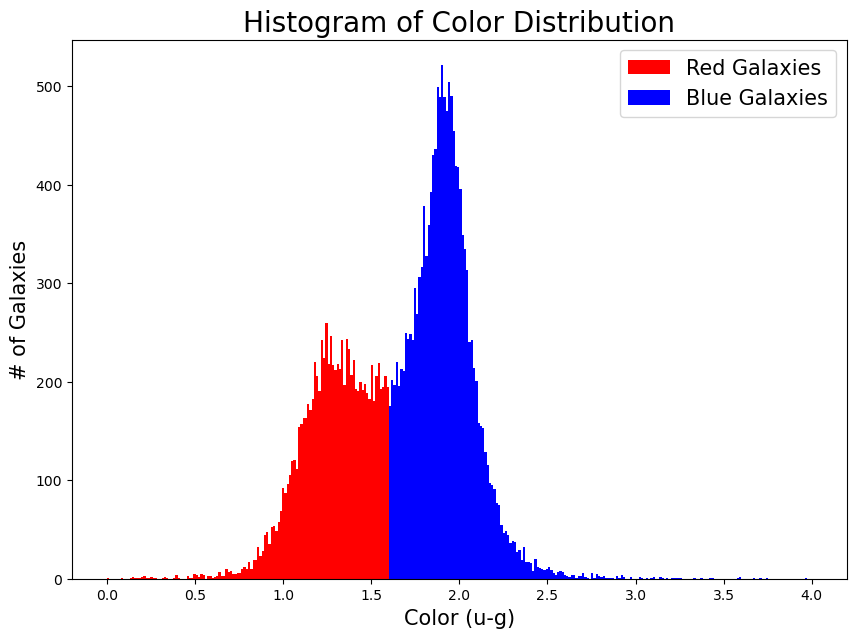

In [12]:
#red-blue color plot
xbins=125
ybins=int(125*((4-mean)/mean))
fig, dist = plt.subplots(figsize = (10,7))
x=np.linspace(0, mean, xbins)
red=dist.hist(color, bins=x, color='r',label="Red Galaxies")
y=np.linspace(mean,4, ybins)
blue=dist.hist(color, bins=y, color='b',label="Blue Galaxies")
plt.xlabel("Color (u-g)", fontsize=15)
plt.ylabel("# of Galaxies", fontsize=15)
plt.title("Histogram of Color Distribution", fontsize=20)
plt.legend(fontsize=15)
plt.savefig('Histogram_of_Color_Distribution.png')

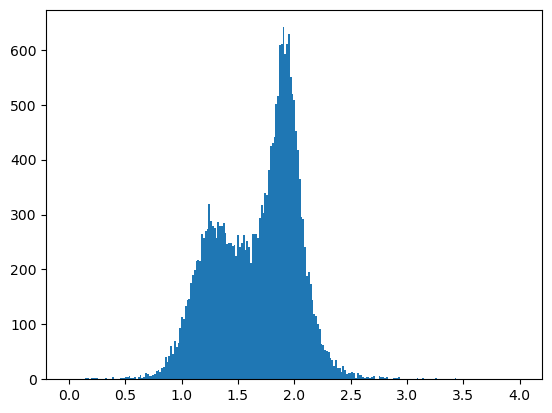

In [13]:
width=np.linspace(0,4,250)
rawhist=plt.hist(color, bins=width)

In [16]:
#splitting red and blue into respective arrays
rc=0
bc=0
for i in range(len(color)):
    if (color[i]<=mean):
        rc+=1
    else:
        bc+=1
red=np.zeros(rc)
rawred=np.zeros(rc)
blue=np.zeros(bc)
rawblue=np.zeros(bc)
rc=0
bc=0
for i in range(len(color)):
    if (color[i]<=mean):
        red[rc]=rmag[i]
        rawred[rc]=SD[4][i]
        rc+=1
    else:
        blue[bc]=rmag[i]
        rawblue[bc]=SD[4][i]
        bc+=1
print(len(blue))
print(len(red))

14796
9585


# Full Luminosity Function

In [17]:
bincount=200

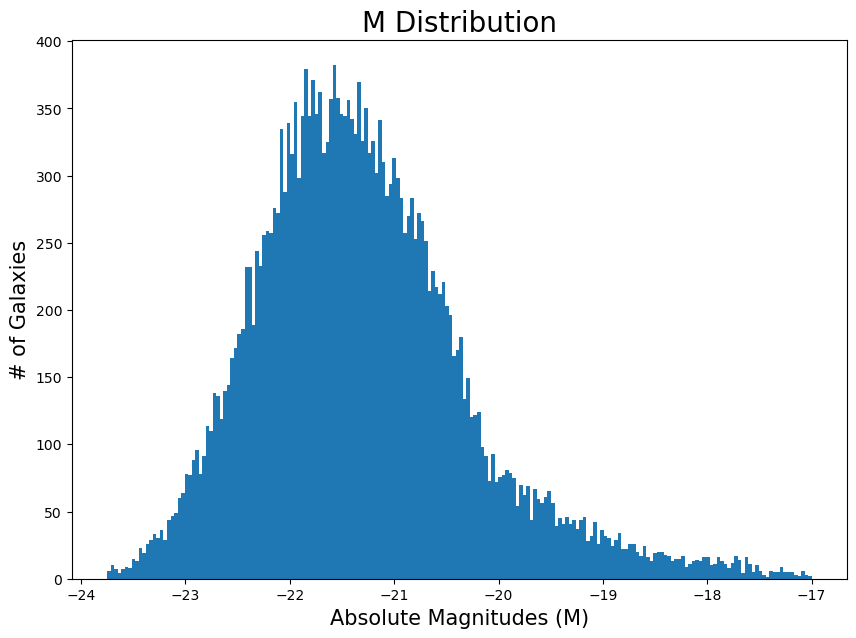

In [18]:
u=np.linspace(-23.75,-17,bincount+1)
fig, dis = plt.subplots(figsize = (10,7))
bis=dis.hist(rmag,bins=u)
plt.xlabel("Absolute Magnitudes (M)", fontsize=15)
plt.ylabel("# of Galaxies", fontsize=15)
plt.title("M Distribution", fontsize=20)
plt.savefig('M_Distribution.png')

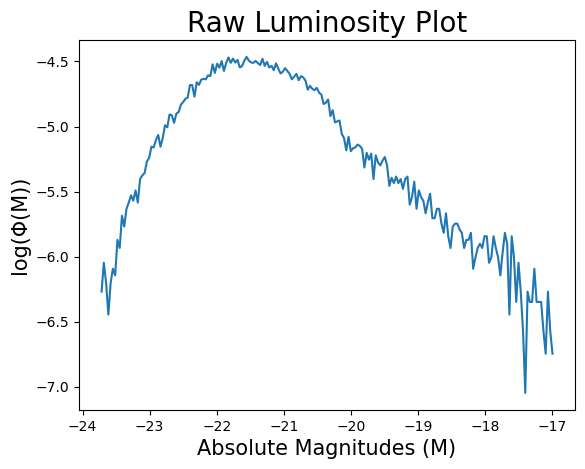

In [19]:
vol=330367757
num=bis[0]/(vol*(bis[1][1]-bis[1][0]))
biss=np.delete(bis[1],0)
raw = plt.plot(biss,np.log10(num))
plt.title("Raw Luminosity Plot", fontsize=20)
plt.xlabel("Absolute Magnitudes (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.savefig('Raw_Luminosity_Plot.png')

In [20]:
mx=-100000
track=None
for i in range(le):
    if (SD[4][i]>mx):
        mx=SD[4][i]
print(mx)

17.599950790405273


## Malmquist Bias

In [21]:
def malm(mx,mag,count,siz):
    mm=(mx-mag)/5
    dist=(pow(10,mm))/1000000
    vol=(0.0316129326)*(pow(dist,3))
    nu=count/(siz*vol)
    return nu

In [22]:
#Adjusting Bins for bias
bias=[None]*bincount
for i in range(bincount):
    bias[i]=malm(mx,bis[1][i],bis[0][i],(bis[1][1]-bis[1][0]))

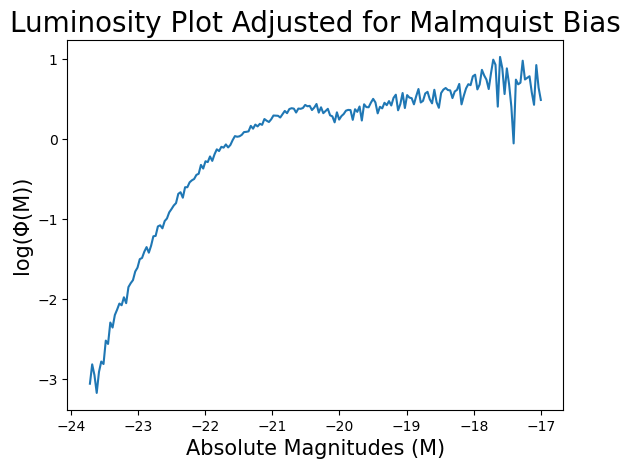

In [23]:
fin=plt.plot(biss,np.log10(bias))
plt.title("Luminosity Plot Adjusted for Malmquist Bias", fontsize=20)
plt.xlabel("Absolute Magnitudes (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize = 15)
plt.savefig('Adjusted_Luminosity_Plot.png')

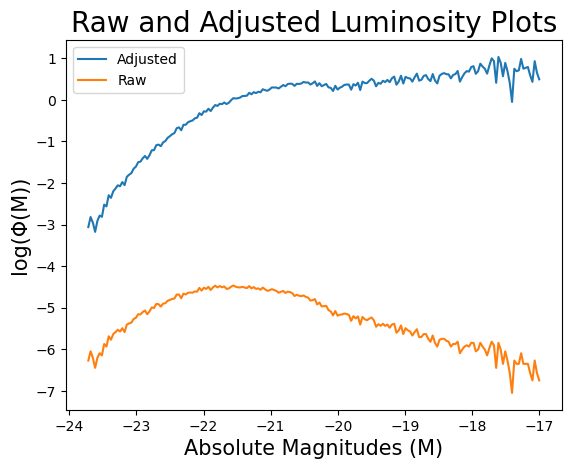

In [24]:
fin=plt.plot(biss,np.log10(bias),label='Adjusted')
plt.plot(biss,np.log10(num),label='Raw')
plt.title("Raw and Adjusted Luminosity Plots", fontsize=20)
plt.xlabel("Absolute Magnitudes (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.legend(fontsize=10)
plt.savefig('Combined_Luminosity_Plots.png')

In [25]:
#Error Calculation
err=np.log10(bias)/pow(bis[0],0.5)

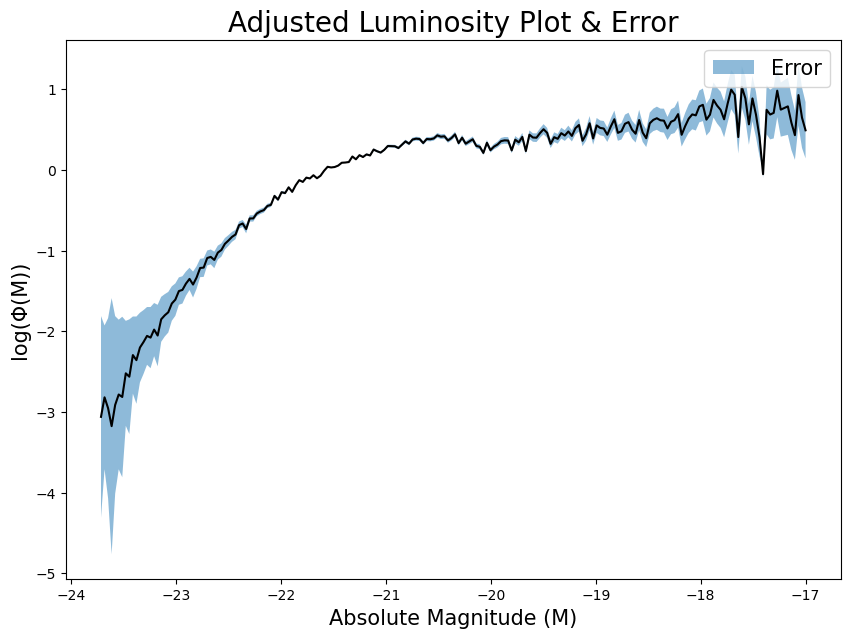

In [26]:
x=biss
y=np.log10(bias)
fig, full=plt.subplots(figsize=(10,7))
full.plot(x,y,'black')
plt.fill_between(x,y-err,y+err,alpha=0.5,label='Error')
plt.title('Adjusted Luminosity Plot & Error', fontsize=20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel('log(Φ(M))', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Luminosity_Error.png')

# Red Luminosity

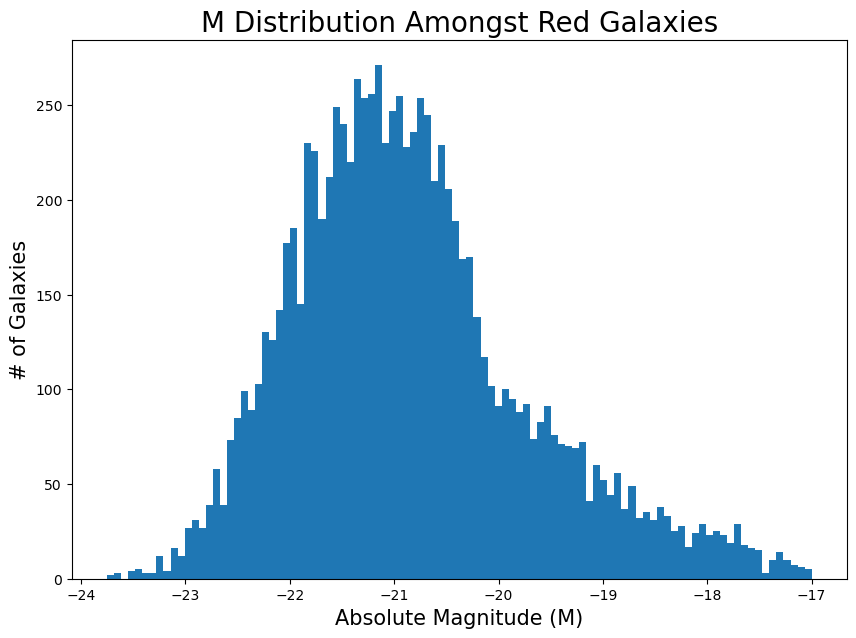

In [27]:
rbin=100
ur=np.linspace(-23.75,-17,rbin+1)
rfig,rdis = plt.subplots(figsize = (10,7))
rbis=rdis.hist(red,bins=ur)
plt.title("M Distribution Amongst Red Galaxies", fontsize = 20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("# of Galaxies", fontsize=15)
plt.savefig('M_Distribution_Red.png')

In [28]:
#Calculating magnitude limit
rmx=-100000
for i in range(len(red)):
    if (rawred[i]>rmx):
        rmx=rawred[i]
print(rmx)
rbiss=np.delete(rbis[1],0)

17.59994125366211


In [29]:
#Adjusting for bias
rbias=[None]*rbin
for i in range(rbin):
    rbias[i]=malm(rmx,rbis[1][i],rbis[0][i],(rbis[1][1]-rbis[1][0]))

C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\4077456124.py:1: RuntimeWarning: divide by zero encountered in log10
  rfin=plt.plot(rbiss,np.log10(rbias),color='r')


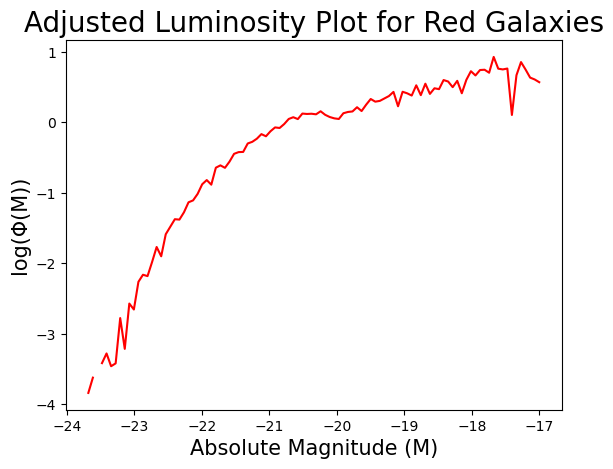

In [30]:
rfin=plt.plot(rbiss,np.log10(rbias),color='r')
plt.title("Adjusted Luminosity Plot for Red Galaxies",fontsize=20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.savefig('Adjusted_Luminosity_Red.png')

In [31]:
#Error calculation
rerr=np.log10(rbias)/pow(rbis[0],0.5)

C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\382179751.py:2: RuntimeWarning: divide by zero encountered in log10
  rerr=np.log10(rbias)/pow(rbis[0],0.5)


C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\3648952772.py:2: RuntimeWarning: divide by zero encountered in log10
  ry=np.log10(rbias)
C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\3648952772.py:5: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(rx,ry-rerr,ry+rerr,alpha=0.5,color='r',label="Error")


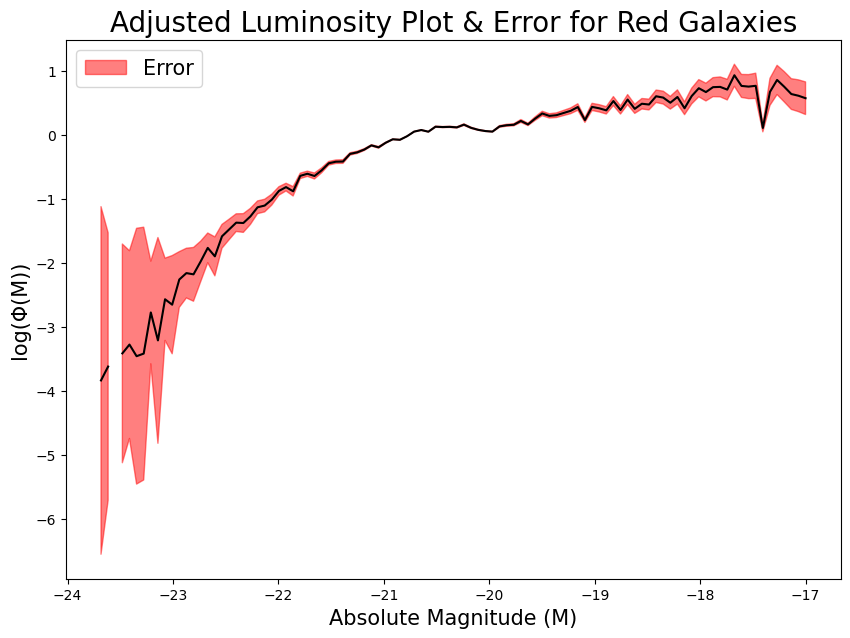

In [32]:
rx=rbiss
ry=np.log10(rbias)
fig, rfull=plt.subplots(figsize=(10,7))
rfull.plot(rx,ry,'black')
plt.fill_between(rx,ry-rerr,ry+rerr,alpha=0.5,color='r',label="Error")
plt.title("Adjusted Luminosity Plot & Error for Red Galaxies", fontsize=20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))",fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Adjusted_Error_Red.png')

# Blue Luminosity

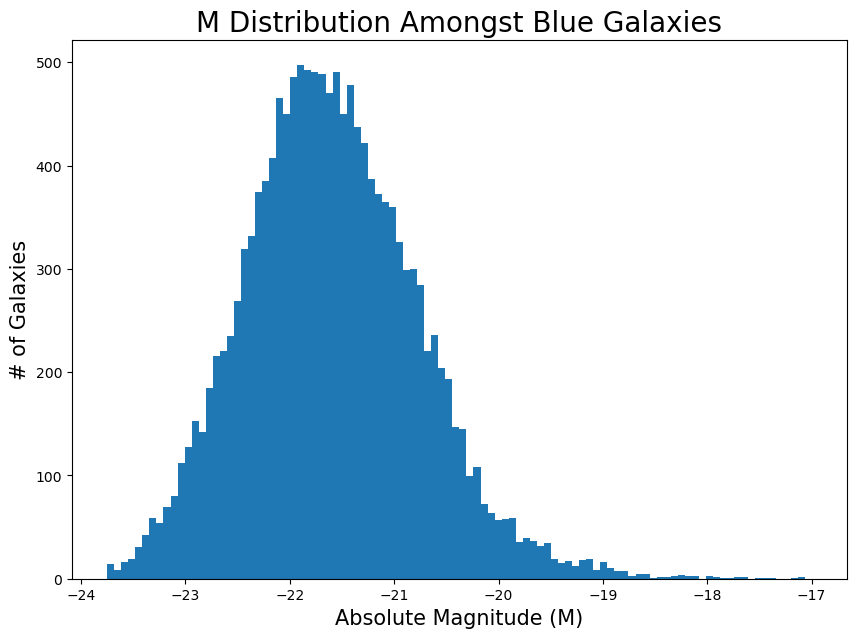

In [33]:
bbin=100
ub=np.linspace(-23.75,-17,bbin+1)
bfig, bdis = plt.subplots(figsize = (10,7))
bbis=bdis.hist(blue,bins=ub)
plt.title("M Distribution Amongst Blue Galaxies", fontsize = 20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("# of Galaxies", fontsize=15)
plt.savefig('M_Distribution_Blue.png')

In [34]:
#Finding apparent mag limit
bmx=-100000
for i in range(len(blue)):
    if (rawblue[i]>bmx):
        bmx=rawblue[i]
print(bmx)
bbiss=np.delete(bbis[1],0)

17.599950790405273


In [35]:
#Adjusting for bias
bbias=[None]*bbin
for i in range(bbin):
    bbias[i]=malm(bmx,bbis[1][i],bbis[0][i],(bbis[1][1]-bbis[1][0]))

C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\2577199147.py:1: RuntimeWarning: divide by zero encountered in log10
  bfin=plt.plot(bbiss,np.log10(bbias),color='b')


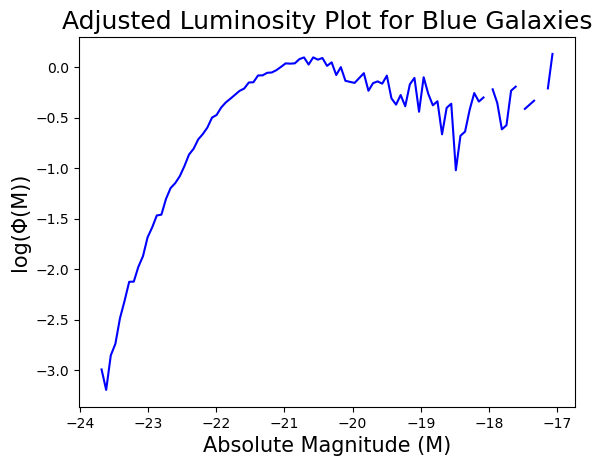

In [36]:
bfin=plt.plot(bbiss,np.log10(bbias),color='b')
plt.title("Adjusted Luminosity Plot for Blue Galaxies",fontsize=18)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.savefig('Adjusted_Luminosity_Blue.png')

In [37]:
#Error calculation
berr=np.log10(bbias)/pow(bbis[0],0.5)

C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\214703384.py:2: RuntimeWarning: divide by zero encountered in log10
  berr=np.log10(bbias)/pow(bbis[0],0.5)


C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\788040524.py:2: RuntimeWarning: divide by zero encountered in log10
  by=np.log10(bbias)
C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\788040524.py:5: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(bx,by-berr,by+berr,alpha=0.5,color='b',label="Error")


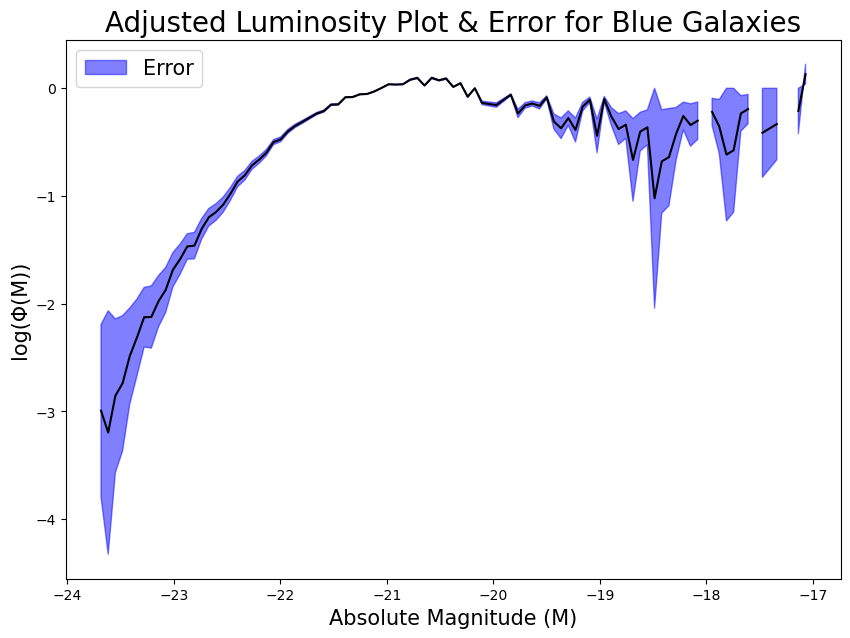

In [38]:
bx=bbiss
by=np.log10(bbias)
fig, bfull=plt.subplots(figsize=(10,7))
bfull.plot(bx,by,'black')
plt.fill_between(bx,by-berr,by+berr,alpha=0.5,color='b',label="Error")
plt.title("Adjusted Luminosity Plot & Error for Blue Galaxies", fontsize=20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))",fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Adjusted_Error_Blue.png')

# Schecter Function

In [39]:
#Schecter function
def schect(c,a,m,ms):
    rpp=(0.4)*(ms-m)
    rp=-pow(10,rpp)
    r=np.exp(rp)
    lp=(-0.4)*(a+1)*(ms-m)
    l=pow(10,lp)
    fun=np.log10(c*l*r)
    return fun
print(np.mean(rmag))

-21.2217521852673


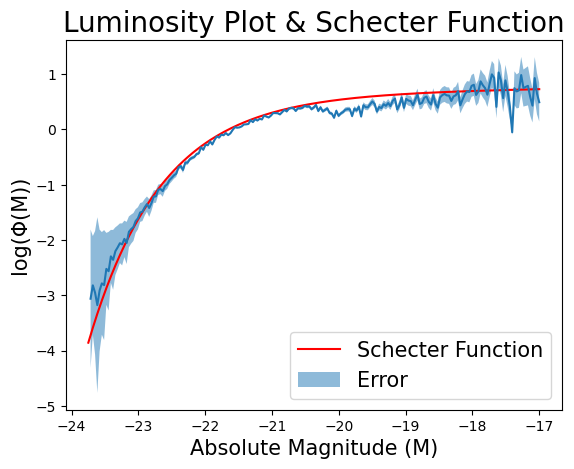

In [40]:
s=np.linspace(-23.75,-17,bincount)
ys=schect(4.5,-.95,s,np.mean(rmag))
plt.plot(s,ys,color='r',label="Schecter Function")
plt.plot(biss,np.log10(bias))
plt.fill_between(x,y-err,y+err,alpha=0.5,label="Error")
plt.title("Luminosity Plot & Schecter Function", fontsize=20)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Plot_Schecter.png')

C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\4044561089.py:2: RuntimeWarning: divide by zero encountered in log10
  rfin=plt.plot(rbiss,np.log10(rbias))
C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\4044561089.py:3: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(rx,ry-rerr,ry+rerr,alpha=0.5,label="Error")


-21.2217521852673


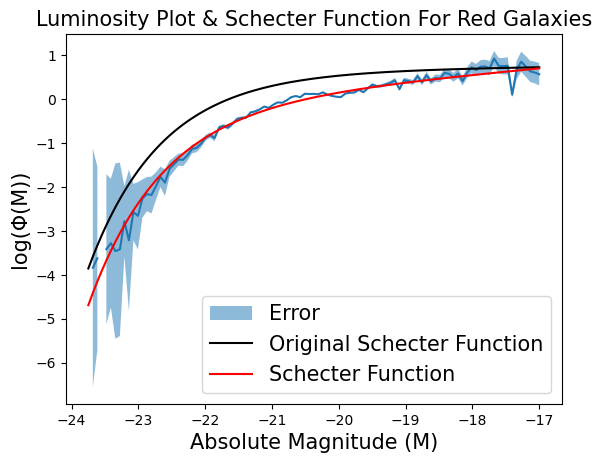

In [41]:
rs=np.linspace(-23.75,-17,bincount)
rfin=plt.plot(rbiss,np.log10(rbias))
plt.fill_between(rx,ry-rerr,ry+rerr,alpha=0.5,label="Error")
rys=schect(1.32,-.65,s,np.mean(rmag))
plt.plot(s,ys,color='black',label="Original Schecter Function")
plt.plot(rs,rys,color='r',label="Schecter Function")
plt.title("Luminosity Plot & Schecter Function For Red Galaxies", fontsize=15)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Plot_Schecter_Red.png')
print(np.mean(rmag))

C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\3461852311.py:2: RuntimeWarning: divide by zero encountered in log10
  bfin=plt.plot(bbiss,np.log10(bbias))
C:\Users\ryanr\AppData\Local\Temp\ipykernel_336\3461852311.py:3: RuntimeWarning: invalid value encountered in subtract
  plt.fill_between(bx,by-berr,by+berr,alpha=0.5,label="Error")


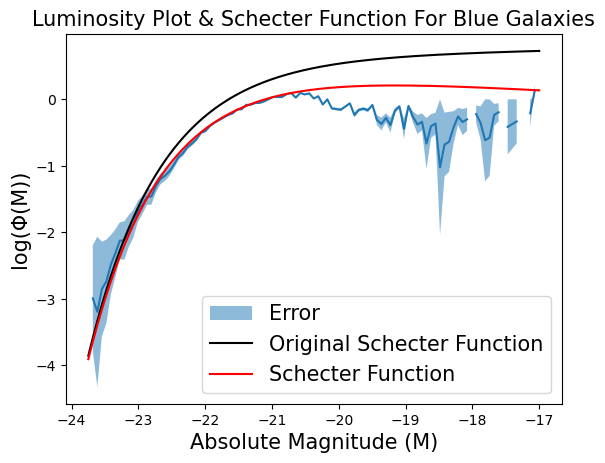

In [42]:
bs=np.linspace(-23.75,-17,bincount)
bfin=plt.plot(bbiss,np.log10(bbias))
plt.fill_between(bx,by-berr,by+berr,alpha=0.5,label="Error")
bys=schect(2.5,-1.15,s,np.mean(rmag))
oys=schect(4.5,-.95,bs,np.mean(rmag))
plt.plot(s,ys,color='black',label="Original Schecter Function")
plt.plot(bs,bys,color='r',label="Schecter Function")
plt.title("Luminosity Plot & Schecter Function For Blue Galaxies", fontsize=15)
plt.xlabel("Absolute Magnitude (M)", fontsize=15)
plt.ylabel("log(Φ(M))", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Plot_Schecter_Blue.png')